In [1]:
#imports 
import os
from collections import Counter
import spacy
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as T
import torch.nn as nn
import torch.optim as optim

from PIL import Image

import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import json
from time import time
import pickle

import nltk
from nltk.corpus import stopwords

from torchvision.models import resnet50, ResNet50_Weights
import torch

import sys
sys.path.append('../src')
from utils import Vocabulary, FlickrDataset, show_image, EncoderDecoder, DecoderRNN

image_path = "../all_images/Flicker8k_Dataset/" 
train_file_path = '../all_captions/Flickr_8k.trainImages.txt'
captions_path = "../all_captions/Flickr8k.token.txt"
test_file_path = '../all_captions/Flickr_8k.testImages.txt'

/home/bruno/Documents/fhnw/show-attend-tell/attend-env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
spacy_eng = spacy.load("en_core_web_sm")

#example
text = "This is a good place to find a city"
[token.text.lower() for token in spacy_eng.tokenizer(text)]

['this', 'is', 'a', 'good', 'place', 'to', 'find', 'a', 'city']

In [3]:
#testing the vicab class 
v = Vocabulary(freq_threshold=1)

v.build_vocab(["This is a good place to find a city"])
print(v.stoi)
print(v.numericalize("This is a good place to find a city here!!"))

{'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3, 'this': 4, 'is': 5, 'a': 6, 'good': 7, 'place': 8, 'to': 9, 'find': 10, 'city': 11}
[4, 5, 6, 7, 8, 9, 10, 6, 11, 3, 3, 3]


In [4]:
def clean_text(text):
  text = text.lower()
  text = re.sub("[^a-z]+", " ", text)
  text = text.split()
  text = [s for s in text if len(s)> 1]
  text = " ".join(text)
  return text

caption_file = open(captions_path, "r").read()

keys = []
caption_list = []

for row in caption_file.split("\n"):
    key = row.split("#")[0].split(".")[0]
    caption = row.split("#")[-1].split("\t")[-1]
    caption = caption.replace('.', '')
    caption = clean_text(caption)

    keys.append(key)
    caption_list.append(caption)

captions = pd.DataFrame(data=zip(keys, caption_list), columns=["image", "caption"])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


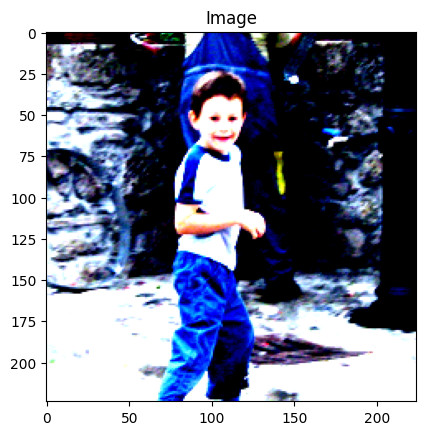

Image shape:  torch.Size([3, 224, 224])
Token:  tensor([  1,  75, 148, 130, 156,  24,  47,   2])
Sentence: 
['<SOS>', 'young', 'boy', 'runs', 'aross', 'the', 'street', '<EOS>']


In [5]:
transform = T.Compose([
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )])
dataset = FlickrDataset("../all_images/Flicker8k_Dataset", captions, transform=transform, freq_threshold=1)
img, caps = dataset[42]
show_image(img, "Image")
print("Image shape: ", img.shape)
print("Token: ", caps)
print("Sentence: ")
print([dataset.vocab.itos[token] for token in caps.tolist()])

In [6]:
BATCH_SIZE = 256
NUM_WORKERS = 1
frequency_threshold = 1

transform = T.Compose([
                T.Resize(256),
                T.CenterCrop(224),
                T.ToTensor(),
                T.Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225]
            )])

def my_collate_fn(batch):
    images_ = list()
    captions_ = list()

    for b in batch:
        images_.append(b[0])
        captions_.append(b[1])

    images_ = torch.stack(images_, dim=0)
    captions_ = pad_sequence(captions_, batch_first=True, padding_value=0)

    return images_, captions_

#reset index to make dataloader indexing work
train_file = open(train_file_path, 'r').read()
train_imgs = [row.split(".")[0] for row in train_file.split("\n")[:-1]]
train_data = captions[captions.image.isin(train_imgs)]
train_data = train_data.reset_index()

test_file = open(test_file_path, 'r').read()
test_imgs = [row.split(".")[0] for row in test_file.split("\n")[:-1]]
test_data = captions[captions.image.isin(test_imgs)]
test_data = test_data.reset_index()


vocab = Vocabulary(frequency_threshold)
vocab.build_vocab(captions.caption.tolist())

train_dataset = FlickrDataset("../all_images/Flicker8k_Dataset", train_data, transform=transform, vocab=vocab)
test_dataset = FlickrDataset("../all_images/Flicker8k_Dataset", test_data, transform=transform, vocab=vocab)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, collate_fn=my_collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, collate_fn=my_collate_fn)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [7]:
for idx, (imgs, captions) in enumerate(iter(train_dataloader)):
    print(len(captions))
    break

256


In [8]:
embed_size = 300
vocab_size = len(vocab)
attention_dim = 256
encoder_dim = 2048
decoder_dim = 512
learning_rate = 0.001

model = EncoderDecoder(embed_size = embed_size, 
    vocab_size = vocab_size, 
    attention_dim = attention_dim, 
    encoder_dim = encoder_dim, 
    decoder_dim = decoder_dim, 
    device = device).to(device)

criterion = nn.CrossEntropyLoss(ignore_index = dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

/home/bruno/Documents/fhnw/show-attend-tell/attend-env/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bruno/Documents/fhnw/show-attend-tell/attend-env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
num_epochs = 25
print_every = 100

for epoch in range(1, num_epochs + 1):
    start = time()
    for idx, (imgs, caps) in enumerate(iter(train_dataloader)):
        imgs = imgs.to(device)
        caps = caps.to(device)

        optimizer.zero_grad()

        outputs, attentions = model(imgs, caps)

        targets = caps[:, 1:]

        loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))

        loss.backward()
        optimizer.step()

        if idx % print_every == 0:
            print(f"Epoch: {epoch} | Step: {idx} | Loss: {loss.item():.4f}")

        model.train()
    print(f"Epoch: {epoch} | Time: {time() - start:.2f} seconds")

Epoch: 1 | Step: 0 | Loss: 9.0257
